The following is from [this article](https://medium.com/towards-data-science/forecast-multiple-time-series-like-a-master-1579a2b6f18d) in Medium.

In this article, I would like to introduce you to the universal (which doesn’t mean ideal) algorithms currently in use for forecasting multiple time series — such as state of the art for time series. For a retailer or manufacturer, forecasting demand is key to business. It allows them to create more accurate production plans and optimize their inventory. Unfortunately, many companies (not Nestlé :) ) don’t see this problem and they use spreadsheets with simple statistics. If they would change this they could significantly reduce their costs. After all, warehousing and out-of-date products — that’s an additional cost.

Here helps us Darts, which tries to be a Scikit-learn for time series, and its purpose is precise to simplify working with time series. Often its functionality is based on other libraries, for example, it uses Statsmodels for decomposition. It also makes Darts work well with other libraries if something isn’t implemented there, you can compare it to how you can mutually use Matplotlib to work with Seaborn.
Where it is necessary they have their own implementations, but they don’t want to reinvent the wheel and use what is already there in other popular libraries for time series.

This idea is not new for time series, and there are other good libraries, such as sktime, GluonTS, or nixtla, but in my opinion, Darts has the lowest entry threshold and is more complete. This is not an advertisement for this library, at the end of the day your forecast should bring value to the business you work for. You might as well write each of these models in code from scratch. I am going to use Darts in the below examples, but you will also be able to find these models (all or part of them) in the libraries mentioned above. I see space for improvement for the Darts library in optimizing computation if we want to train multiple local models ~ this tries nixtla library, which offers compatibility with Spark, Dask, and Ray.

From my perspective, Darts is already a mature library and it is still being developed, just look at the changelog. Now you can install it in the standard way:

In [1]:
import darts

# Single vs Multiple time series

<img src="figures/Warmart.webp" style="width:700px;height:350px;background-color:white">

Above, based on the [Walmart dataset](https://www.kaggle.com/datasets/yasserh/walmart-dataset/), you can see single and multiple time series. Nowadays, many problems involve multiple points at the same time. This data can come from a variety of processes, it can be this example and my daily work which is demand forecasting, but it can also be energy consumption forecasting, the closing price of a company on the stock market, the number of bicycles rented from a station and many many others problems.

In addition to the time series itself, we may also have other variables for them, some of which may be known for the future and others only available for the past — about that in a moment.

In this article, I want to show you different approaches for forecasting multiple time series, but I want it to be practical — so that you are not left with just theory. So let’s import all the libraries used later — darts and others well known by Data Scientists.

In [2]:
# multiprocessing
# settings
import warnings

# data visualization
import matplotlib.pyplot as plt

# data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
from darts import TimeSeries

# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler

# evaluation
from darts.metrics import mape

# models
from darts.models import (  # local; global
    ExponentialSmoothing,
    LightGBMModel,
    NaiveSeasonal,
    NBEATSModel,
    Prophet,
    RNNModel,
    StatsForecastAutoARIMA,
    TFTModel,
)

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from joblib import Parallel, delayed
from tqdm import tqdm

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Now let’s load the dataset, which is about demand forecasting and comes from the [Kaggle](https://www.kaggle.com/competitions/demand-forecasting-kernels-only). If you agree with the terms of the competition on Kaggle then you can also download this dataset.

In [3]:
dataset = pd.read_csv("store_item_demand.csv")

In [4]:
dataset

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [5]:
# set the column type for column with date
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y-%m-%d")

In [6]:
# sort values and reset index
dataset.sort_values(by=["date", "store", "item"], inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [7]:
dataset

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,2,33
2,2013-01-01,1,3,15
3,2013-01-01,1,4,10
4,2013-01-01,1,5,11
...,...,...,...,...
912995,2017-12-31,10,46,70
912996,2017-12-31,10,47,22
912997,2017-12-31,10,48,60
912998,2017-12-31,10,49,42


In [8]:
# creation of an auxiliary table with hierarchy and aggregated sales totals
hierarchy_df = dataset.groupby(["store", "item"])[["sales"]].sum()

In [9]:
hierarchy_df

sales
store item        
1     1      36468
      2      97050
      3      60638
      4      36440
      5      30335
...            ...
10    46    120601
      47     45204
      48    105570
      49     60317
      50    135192

[500 rows x 1 columns]

In [10]:
hierarchy_df = (
    hierarchy_df.reset_index(drop=False)
    .sort_values(by=["sales"], ascending=False)
    .reset_index(drop=True)
)

In [11]:
hierarchy_df

,store,item,sales
0,2,28,205677
1,2,15,205569
2,2,18,197422
3,8,15,197295
4,2,13,197031
...,...,...,...
495,7,27,27780
496,7,1,27681
497,5,5,25722
498,6,5,25369


There are 10 stores and in each of them are 50 items making a total of 500 time series.

Let’s take a look at the 10 among the least, median, and most sold in total store-item combinations. To find what relations are in a time series it is often enough to look at it because this already tells us a lot, like a trend or seasonality, but often much more.

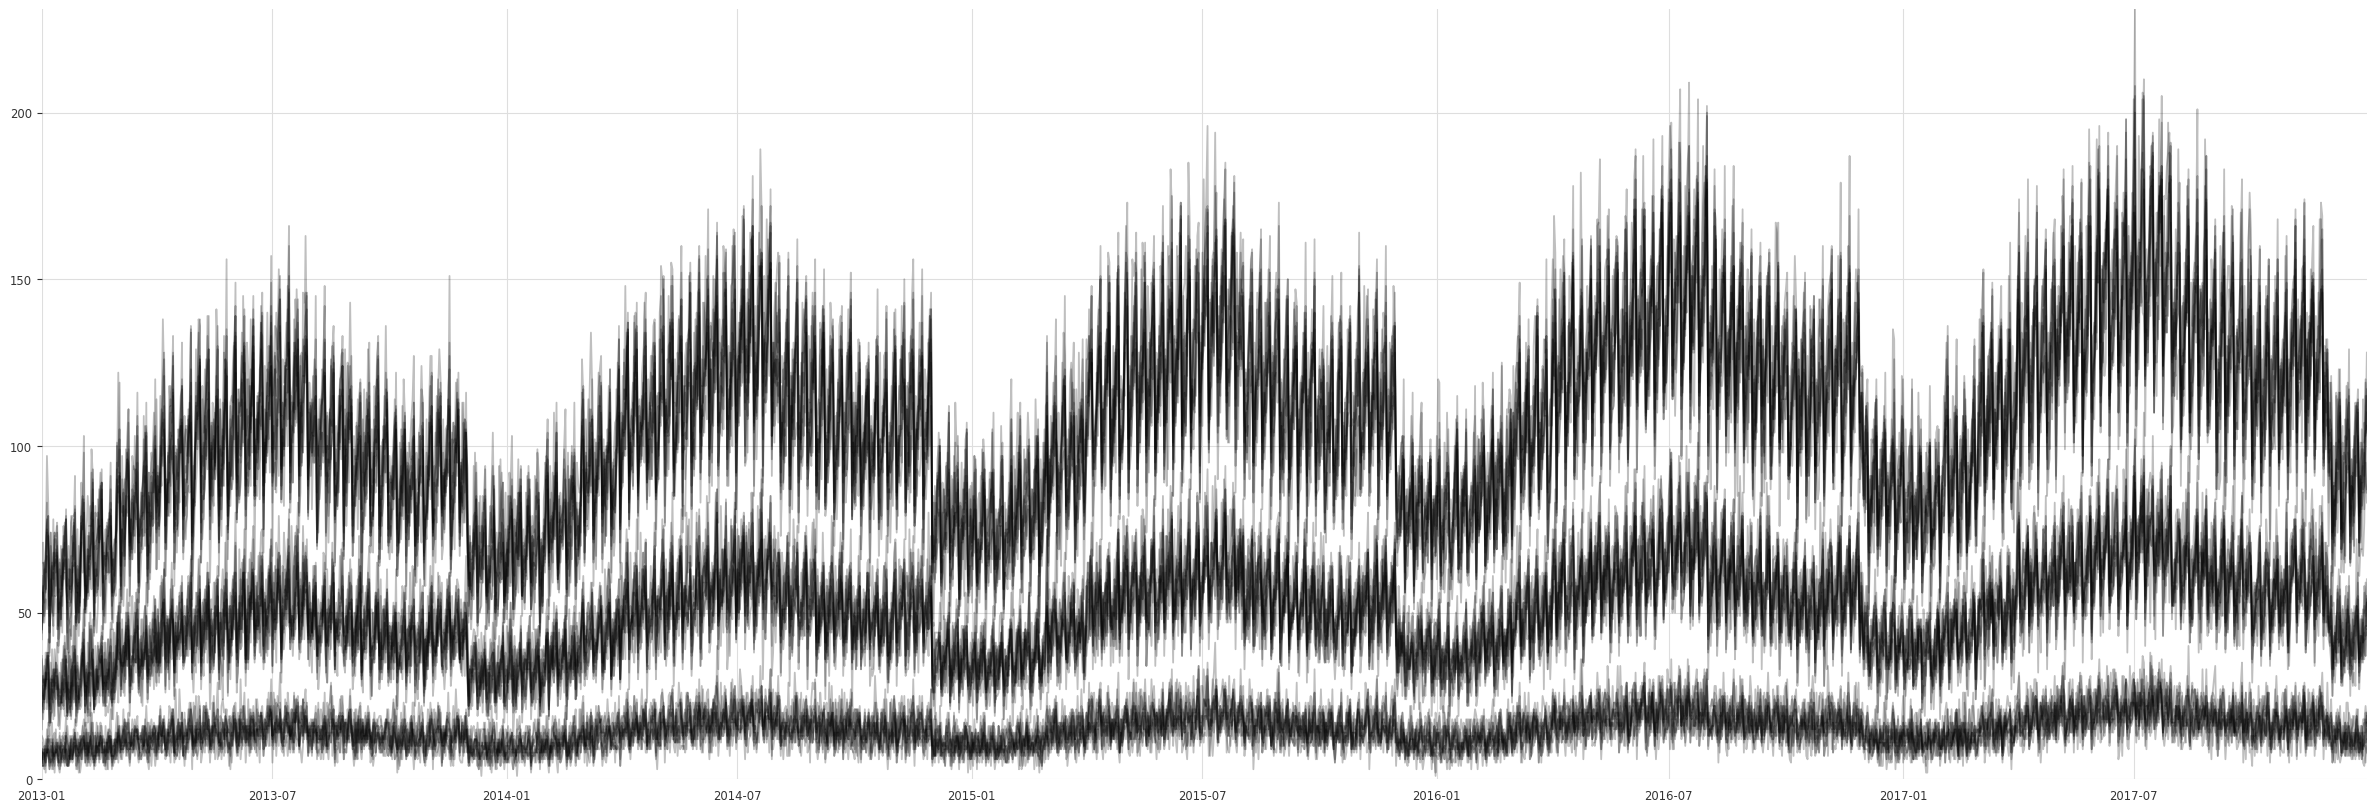

In [12]:
fig, ax = plt.subplots(figsize=(30, 10))

for single_ts in (
    list(np.arange(0, 10)) + list(np.arange(245, 255)) + list(np.arange(490, 500))
):
    single_ts_df = pd.merge(
        dataset,
        hierarchy_df.loc[[single_ts], ["store", "item"]],
        how="inner",
        on=["store", "item"],
    )
    ax.plot(single_ts_df["date"], single_ts_df["sales"], color="black", alpha=0.25)
ax.set_xlim([dataset["date"].min(), dataset["date"].max()])
ax.set_ylim([0, dataset["sales"].max()])
plt.show()

There is a lot of similarity between these time series. We’ll check for the existence of seasonality (day of the week or week/month of the year) or trend in a moment, but you can already intuitively imagine that model learning relationships from all time series will be able to forecast one single time series better than if it only learned from its history.

I create a copy of my dataset for EDA (exploratory data analysis). Then I scale the time series using MinMAXScaler and then all the time series will be comparable to each other. Finally, I create Box Plots with which I check if there is a trend and seasonality.

In [13]:
# make copy of df
dataset_scaled_EDA = dataset.copy()

In [14]:
dataset_scaled_EDA

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,2,33
2,2013-01-01,1,3,15
3,2013-01-01,1,4,10
4,2013-01-01,1,5,11
...,...,...,...,...
912995,2017-12-31,10,46,70
912996,2017-12-31,10,47,22
912997,2017-12-31,10,48,60
912998,2017-12-31,10,49,42


In [15]:
# min max value calculation
dataset_scaled_EDA["min_sales"] = dataset_scaled_EDA.groupby(["store", "item"])[
    "sales"
].transform(lambda x: x.min())
dataset_scaled_EDA["max_sales"] = dataset_scaled_EDA.groupby(["store", "item"])[
    "sales"
].transform(lambda x: x.max())

In [16]:
dataset_scaled_EDA

,date,store,item,sales,min_sales,max_sales
0,2013-01-01,1,1,13,4,50
1,2013-01-01,1,2,33,13,115
2,2013-01-01,1,3,15,8,70
3,2013-01-01,1,4,10,4,43
4,2013-01-01,1,5,11,3,37
...,...,...,...,...,...,...
912995,2017-12-31,10,46,70,23,125
912996,2017-12-31,10,47,22,6,56
912997,2017-12-31,10,48,60,21,120
912998,2017-12-31,10,49,42,6,69


In [17]:
# scale
dataset_scaled_EDA["sales_scaled"] = (
    dataset_scaled_EDA["sales"] - dataset_scaled_EDA["min_sales"]
) / (dataset_scaled_EDA["max_sales"] - dataset_scaled_EDA["min_sales"])

In [18]:
# add info about year, week of year and day of week
dataset_scaled_EDA["year"] = dataset_scaled_EDA["date"].dt.year
dataset_scaled_EDA["month"] = dataset_scaled_EDA["date"].dt.month
dataset_scaled_EDA["day_of_week"] = [
    d.strftime("%A") for d in dataset_scaled_EDA["date"]
]
dataset_scaled_EDA["day_of_week"] = pd.Categorical(
    dataset_scaled_EDA["day_of_week"],
    categories=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    ordered=True,
)

In [19]:
dataset_scaled_EDA

,date,store,item,sales,min_sales,max_sales,sales_scaled,year,month,day_of_week
0,2013-01-01,1,1,13,4,50,0.195652,2013,1,Tuesday
1,2013-01-01,1,2,33,13,115,0.196078,2013,1,Tuesday
2,2013-01-01,1,3,15,8,70,0.112903,2013,1,Tuesday
3,2013-01-01,1,4,10,4,43,0.153846,2013,1,Tuesday
4,2013-01-01,1,5,11,3,37,0.235294,2013,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-31,10,46,70,23,125,0.460784,2017,12,Sunday
912996,2017-12-31,10,47,22,6,56,0.320000,2017,12,Sunday
912997,2017-12-31,10,48,60,21,120,0.393939,2017,12,Sunday
912998,2017-12-31,10,49,42,6,69,0.571429,2017,12,Sunday


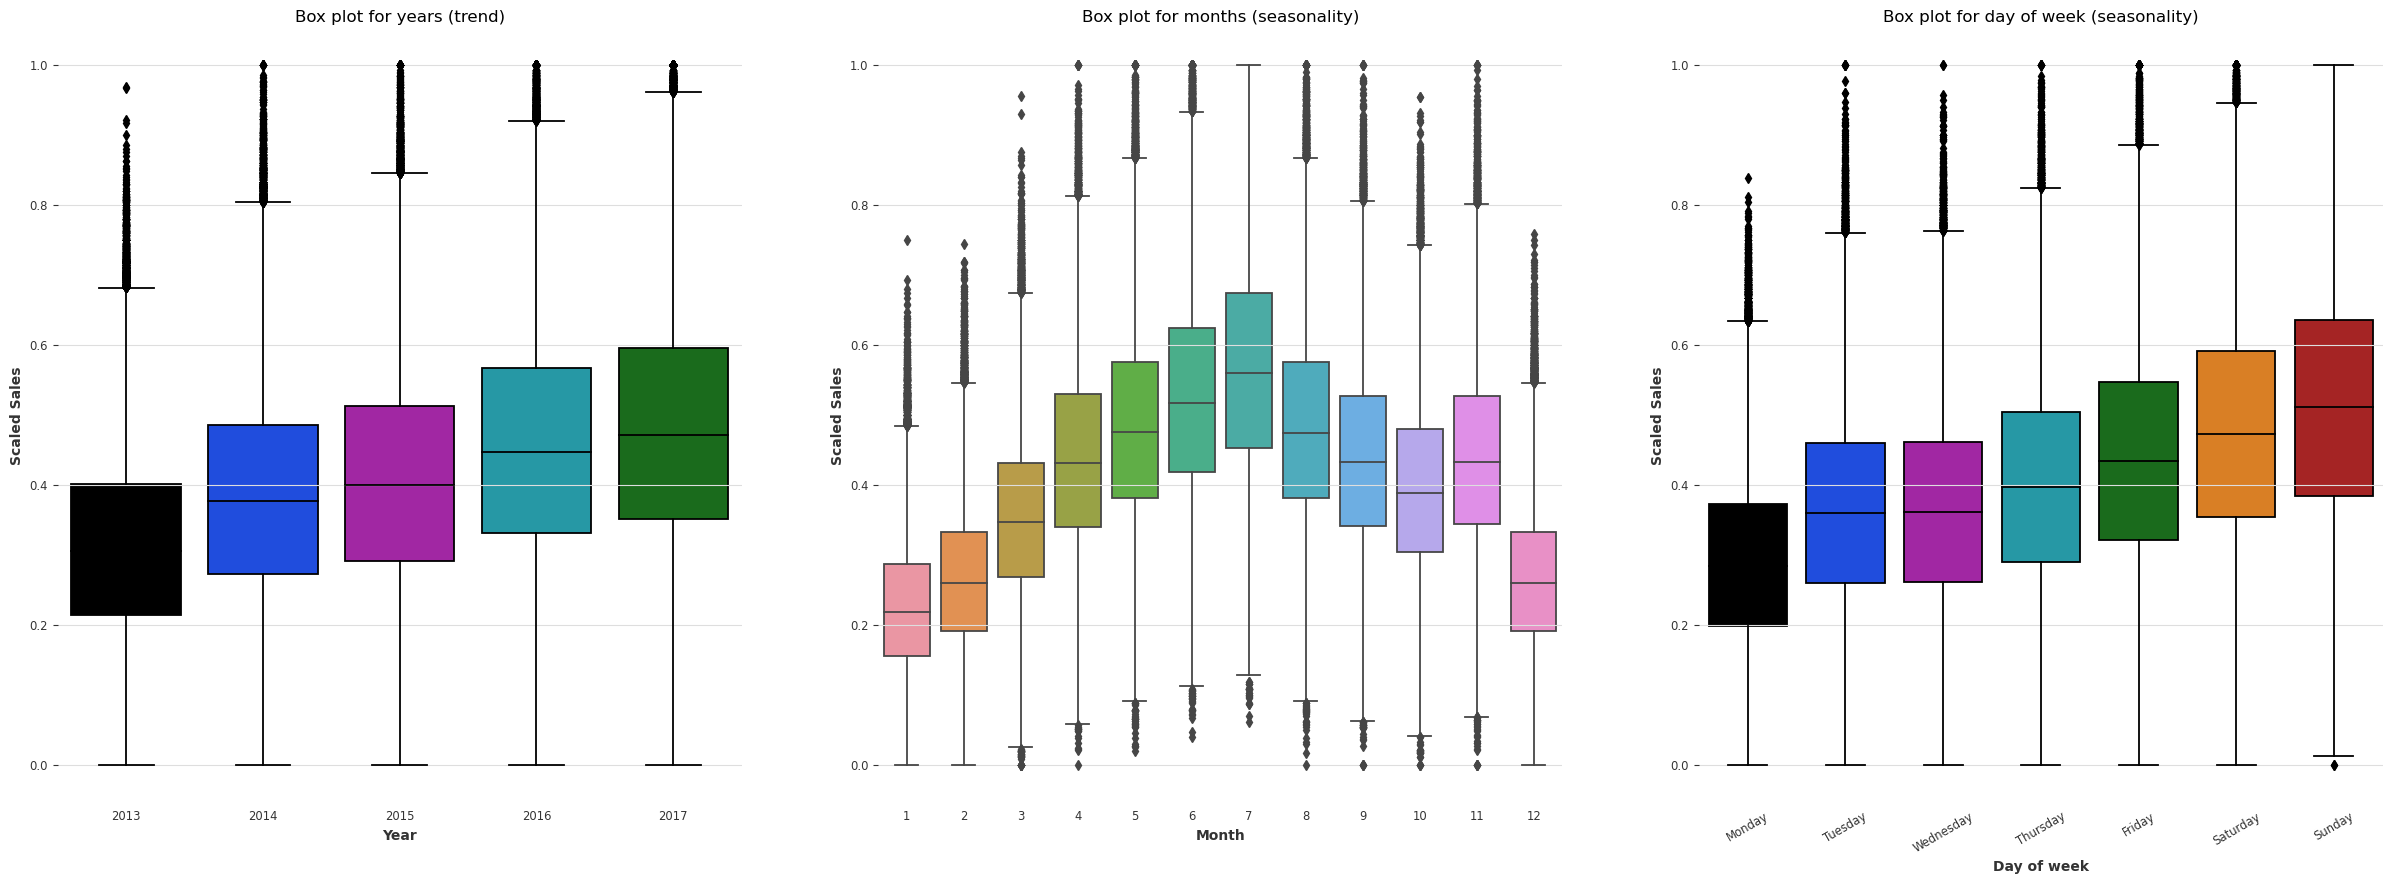

In [20]:
# visualize
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
sns.boxplot(x="year", y="sales_scaled", data=dataset_scaled_EDA, ax=ax[0]).set(
    xlabel="Year", ylabel="Scaled Sales"
)
ax[0].set_title("Box plot for years (trend)")
sns.boxplot(x="month", y="sales_scaled", data=dataset_scaled_EDA, ax=ax[1]).set(
    xlabel="Month", ylabel="Scaled Sales"
)
ax[1].set_title("Box plot for months (seasonality)")
sns.boxplot(x="day_of_week", y="sales_scaled", data=dataset_scaled_EDA, ax=ax[2]).set(
    xlabel="Day of week", ylabel="Scaled Sales"
)
ax[2].set_title("Box plot for day of week (seasonality)")
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=30)
plt.show()

Yes, there is a trend and two types of seasonality. If you think that these time series are easy to forecast —you are right. The purpose of this article is to show you the most popular approaches to forecasting multiple time series. The data is not always as easy as, for example, stock market indexes, but that’s a topic for another article.

I think this exploration is enough to understand what relationships the model should learn.

Here we have multiple time series (sales of multiple items in multiple stores). For each time series, let’s create a TimeSeries object from a Pandas DataFrame. This type is required by models from the Darts library. Then save these time series in a list.

In [21]:
dataset_ts = dataset.copy()

In [22]:
dataset_ts = TimeSeries.from_group_dataframe(
    df=dataset_ts, group_cols=["store", "item"], time_col="date", value_cols="sales"
)

Working with multiple time series can be helpful, but often it is problematic. When we have one time series then we have a lot of time to work with it. Look at it, verify the trend and seasonality, and transform anomalies. We can polish our Forecast. For multiple series this approach becomes impossible. We want the approach to be as automatic as possible, but then we may miss details, such as anomalies, or perhaps we should not process each time series in the same way. There may be more typical problems: missing data, data drift, and rare events (black swans). More series can potentially help us because our model will be able to use more data, and therefore there will be more representative observations for a particular pattern. Using my work as an example — to forecast the demand caused by a promotion for product X in the following week, our model can also use the historical effects of such a promotion from other promotions.

> Hence the question — how to forecast multiple time series?

You may often ask yourself Do I have a multiple or multivariate time series?. These questions are legitimate and the answer is not always clear. When your time series are from a single process, are interconnected, correlated, and interact with each other then the answer will be my time series are multivariate.
When you forecast sales of product X in multiple stores then you have a multiple time series, but when you have an additional product Y then for a single store you have a multivariate time series, because sales of one product in a store can affect sales of another, or it can affect — it was only an assumption.

# How to evaluate the forecast?

Before we get into the different approaches and models, let’s discuss first how to measure the quality of a forecast. This is a regression problem, so we will still compare forecasts to true values, here there is no doubt. You can use metrics familiar to the regression problem, such as RMSE(Root Mean Squared Error), MSE(Mean Squared Error), MAE(Mean Absolute Error), or more typical time series metrics such as MAPE(Mean Absolute Percentage Error), MARRE(Mean Absolute Ranged Relative Error) or MASE(Mean Absolute Scaled Error). Further discussion will use MAPE as an evaluation metric. This article is not about demand forecasting, but because of the data and my experience, there are many references to it. So what metric to choose for that problem you can think. Always the metric should reflect the business objective. In this article, Nicolas Vandeput described the metrics used for demand forecasting as KPIs.

We can extend this approach to multiple series and then calculate our metrics for all series at once or for each series separately and then aggregate them. So let’s move on to how to evaluate a single series. Then this can be extended to multiple.

Yes, this is a regression problem, you may wonder why I explain it. In time series, time plays a key role. The data are sorted relative to time, and the observations are relative to each other. Therefore, it is not possible to use randomization when dividing the training/test set and use cross-validation, because in this situation there would be data leakage.

<img src="figures/evaluation_of_forecasting_model.webp" style="width:700px;height:400px;background-color:white">

First, divide the data into a train set and a test set, easy right? The model fits on the train set and tests on the test set. We can divide this proportionally, for example, the test set includes 20% of the last weeks, or indicate from which date the test set is to be — perhaps due to business considerations it is important that the test set is the last year.

In our example, the test set will be the last year.

In [23]:
first_test_date = pd.Timestamp("2017-01-01")
train_dataset_ts, test_dataset_ts = [], []

for single_ts in tqdm(dataset_ts):
    # split into train and test tests
    single_train_ts, single_test_ts = single_ts.split_before(first_test_date)
    train_dataset_ts.append(single_train_ts)
    test_dataset_ts.append(single_test_ts)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.02it/s]


From the train set, we separate validation subsets, which we use to select hyperparameters. For models implemented in Darts, we can use the gridsearch method, but for models based on neural networks, the Optuna is recommended. The gridsearch method actually has everything we need and works the same regardless of which model we choose.
What’s important:

- `parameters` ➜ a dictionary with hyperparameters to check
- `series` ➜ TimeSeries object or a list containing TimeSeries objects (if the algorithm is global)
- `start` ➜ Pandas Timestamp defines when the first forecast will occur or float as the proportion of observations before the first forecast.
- `forecast_horizon` ➜ number(int) of forecast horizons by the model.
- `stride` ➜ Offset between next predictions. To make everything in accordance with the art of Data Science and most reflect the actual operation of the algorithm then stride should be equal to 1. But remember, after each step your algorithm is retrained and your grid of hyperparameters may have a lot of combinations, it often takes ages. Therefore, for common sense reasons, a stride can be higher than 1, especially since the purpose of this is to select the best hyperparameters and the result may (though not necessarily) be the same for a stride equal to 1 as for a stride equal to 5.
- `metric` ➜ function, which compares true values and predictions. The best hyperparameters are then selected based on this metric.

So how to evaluate the model on the test set? We have 2 approaches.
The first is that we fit our model on the train set and make one forecast that covers the test set. In the following examples, we will use this option — it is simply faster to calculate since we generate one forecast for each time series.
The second approach is that we test different forecast horizons. We fit the model, make a forecast, retrain, make a forecast, and so on, but we have to start training the algorithm first before the end of the train set, and that’s so that we can compare horizons on the same data — we’re comparing apples to apples. If you were to start by training on the entire train set then the further horizons have fewer observations. In this method, we should retrain (especially in local models), so we definitely have more calculations in this approach.

It’s also simple because the models in darts have the ability to return historical predictions according to the above visualization. You have already learned about some of the variables in the gridsearch method, which work the same here. However, there will be new variables here:

- `retrain` ➜ if equal to True, then after each step the model is retrained, which best reflects reality.
- `overlap_end` ➜ if equal to True, then the predictions may extend beyond the dates in the test set. Useful if, we are doing a forecast for several horizons and the farther ones are beyond the test set and the closer ones are not.
- `last_points_only` ➜ if equal to False, then the forecast for all horizons is returned.

However, we want to take forecasts from the interested us horizon, and in the variable backtests_results, there are forecasts from different points in time. To take forecasts from the specific horizon then you can use my function `take_backtest_horizon`.

`backtests_5W` ➜ there are forecasts for each point of the test set that were made 5 weeks earlier.

In [24]:
def take_backtest_horizon(backtests, horizon, last_horizon, observations):
    backtests_horizon_dates = [
        i.time_index[-1 + horizon]
        for i in backtests[last_horizon - horizon :][:observations]
    ]
    backtests_horizon_values = [
        i.values()[-1 + horizon]
        for i in backtests[last_horizon - horizon :][:observations]
    ]

    backtests_horizon = TimeSeries.from_times_and_values(
        times=pd.DatetimeIndex(backtests_horizon_dates),
        values=np.array(backtests_horizon_values),
    )
    return backtests_horizon

# Variabls Used

In fact, the time series themselves are not fully explainable by themselves. Often, time series are dependent on other variables. Here we don’t have them, but good to know how to distinguish them when they will appear in your projects. If we do not inform the model about an upcoming promotion/lower price then it will not be able to forecast increased sales. If you want to forecast the change in the price of a stock company, helpful can be added variables from technical or fundamental analysis. These variables are dependent on the price, that is, you can only know these indicators for the past, after all, we do not know the company’s financial reports in the future or its price — we want to forecast it :)

<img src="figures/forecasting_variables.webp" style="width:700px;height:400px;background-color:white">

We can have variables that are also time series, that is, for different points in time they have different values, and we can have static covariates (constant over time), usually categorical variables. In our example that will be store ID and item ID. They are very relevant to global models. Because in 1 out of 100 time series, you may have different relationships, and thanks to this variable your model can distinguish between time series.

As for variables that are time series, we can distinguish between covariates that are also known for the future (for example we can know what the promotional mechanisms are in the future and also we know them for the past) and covariates known only for the past (we can know what price competing products had, but we do not know what they will have in the future).

# Models used

<img src="figures/local_and_global_algorithms.webp" style="width:700px;height:350px;background-color:white">

We can separate machine learning into supervised learning, unsupervised learning, and reinforcement learning. When we get into the details, we can divide supervised learning into regression and classification. We can make a similar split for time series forecasting, which is using local or global algorithms to forecast these time series.

The local algorithm is fitted on a single time series, and only this time series can the model predict. More time series mean more models. Here we see pros and cons, simple models, but for many time series, this approach becomes difficult to maintain.

The global algorithm, on the other hand, is that one model can be fitted on multiple time series. So if we have multiple time series then we can have one model that can forecast them all. This approach is definitely more flexible, for example, you could use Transfer Learning. For time series it means that you fit the model on a different time series than you are making the prediction. [Here](https://unit8co.github.io/darts/examples/14-transfer-learning.html) is an example of this usage. One more important point related to global models, because I could forget it later and it is really important — that is, time series scaling. The most common approach is MinMaxScaler, but you can use something more specific for your data. Nevertheless, I’m not going to write here how you can scale time series, that’s definitely a topic for another article. Let’s consider why we should scale our time series. The answer may be simple, many global algorithms are neural networks and it is a reason why we scale data, as we do with pixels for convolutional neural networks. However, this is not the full picture. However, we can use a model like Random Forest (nonparametric models) and we still should scale them. But STOP, why? After all, for these types of models, you don’t need to scale the variables. The reason we should scale the time series is so that the model learns the relationship, not the scale, for example, for seasonality such a relationship might be that in the summer months, the value is on average 150% higher than in the winter months. Another example would be that after 3 significant increases are followed by a decrease. It is difficult to learn these relationships by the model if we do not scale time series. This is a slightly different approach to scaling a variable for tabular data because here we scale each time series separately. If we use the mentioned MinMaxScaler then for each time series from the train set the maximum value is 1. So let’s scale our data, which will be used by global models.

In [25]:
scaler = Scaler()  # MinMaxScaler

In [26]:
train_dataset_ts_prepared = scaler.fit_transform(train_dataset_ts)
test_dataset_ts_prepared = scaler.transform(test_dataset_ts)
dataset_ts_prepared = scaler.transform(dataset_ts)

In a moment you will read about the most popular local and global algorithms. It is impossible to describe all possible algorithms, but there are a few that are often used by specialists and usually meet expectations.

### No free lunch theorem

There is no answer — this model is the best, do not use others. Nevertheless, if you are creating an MVP — it is best to start with something simple.

In the following examples, I do not choose the best hyperparameters on validation sets, I use default models. So if you write to me that the model may have better results — I already agree with you.

# 1. Local models

Before we move on to specific local models, I have prepared functions for you to use multiprocessing for faster calculations using all Cores.

In [27]:
forecast_horizons = len(test_dataset_ts[0])

In [28]:
forecast_horizons

365

In [29]:
def _backtests_local_estimator(
    _estimator, _ts_set, _split_date, _horizons, _single_forecast
):
    model = _estimator
    if _single_forecast:
        model.fit(_ts_set.split_before(_split_date)[0])
        backtests_single_ts = model.predict(_horizons)

    else:
        backtests_single_ts = model.historical_forecasts(
            series=_ts_set,
            start=_split_date - np.timedelta64(_horizons - 1, "D"),
            verbose=False,
            overlap_end=False,
            last_points_only=True,
            forecast_horizon=_horizons,
            retrain=True,
        )

    return backtests_single_ts

In [30]:
def backtests_multiple_local_estimators(
    estimator,
    multiple_ts_sets=dataset_ts,
    split_date=first_test_date,
    horizons=forecast_horizons,
    single_forecast=True,
):
    backtests_multiple_ts = [
        _backtests_local_estimator(
            _estimator=estimator,
            _ts_set=single_ts_set,
            _split_date=split_date,
            _horizons=horizons,
            _single_forecast=single_forecast,
        )
        for single_ts_set in multiple_ts_sets
    ]

    ## The following doesn't work well in Windows
    ## (Refer to https://stackoverflow.com/questions/35452694/python-joblib-parallel-on-windows-not-working-even-if-name-main)
    # backtests_multiple_ts = Parallel(
    #     n_jobs=-1, verbose=5, backend="multiprocessing", pre_dispatch="1.5*n_jobs"
    # )(
    #     delayed(_backtests_local_estimator)(
    #         _estimator=estimator,
    #         _ts_set=single_ts_set,
    #         _split_date=split_date,
    #         _horizons=horizons,
    #         _single_forecast=single_forecast,
    #     )
    #     for single_ts_set in multiple_ts_sets
    # )

    return backtests_multiple_ts

I am going to use this function for local models to generate a single prediction for the test set. Also, you can use it to generate multiple historical forecasts (the second approach, variable single_forecast should be False). Nevertheless, I do not do that here, because it would take a lot of time.

If you use Cluster and Spark then you can use Spark UDF and speed up the calculations significantly.

I know, you probably want to move to the models part. Last but not least — a function to evaluate our forecasts. I am going to use MAPE as a metric for evaluation, however, if you work on a demand forecasting project then WMAPE or MAE is definitely closer to business expectations.

In [31]:
def get_overall_MAPE(prediction_series, test_series=test_dataset_ts):
    return np.round(
        np.mean(
            mape(actual_series=test_series, pred_series=prediction_series)
            # mape(actual_series=test_series, pred_series=prediction_series, n_jobs=-1)
        ),
        2,
    )

## 1.1. Baseline

Well, okay, but why make a neural network if a better idea is to forecast the value from a year ago? That’s exactly why we create such a model first. When you work with real data, you’d better start with such an approach too (it can also be the last value from the training set, NaiveDrift if there’s a trend or a combination of several simple methods). Then if you move on to more advanced methods you can evaluate how much better it is than the simpler ones, because if, for example, you start with a neural network and its MAPE is 10% then my question (probably also stakeholders) is — Is it good?

Our models(one ts=one model) below will repeat the value from a year ago.

In [32]:
backtests_baseline_model = backtests_multiple_local_estimators(
    estimator=NaiveSeasonal(K=365)
)
print(f"overall MAPE: {get_overall_MAPE(backtests_baseline_model)}%")

overall MAPE: 22.42%


Now let’s visualize the forecast and true value on a test set for time series with the highest total sales.

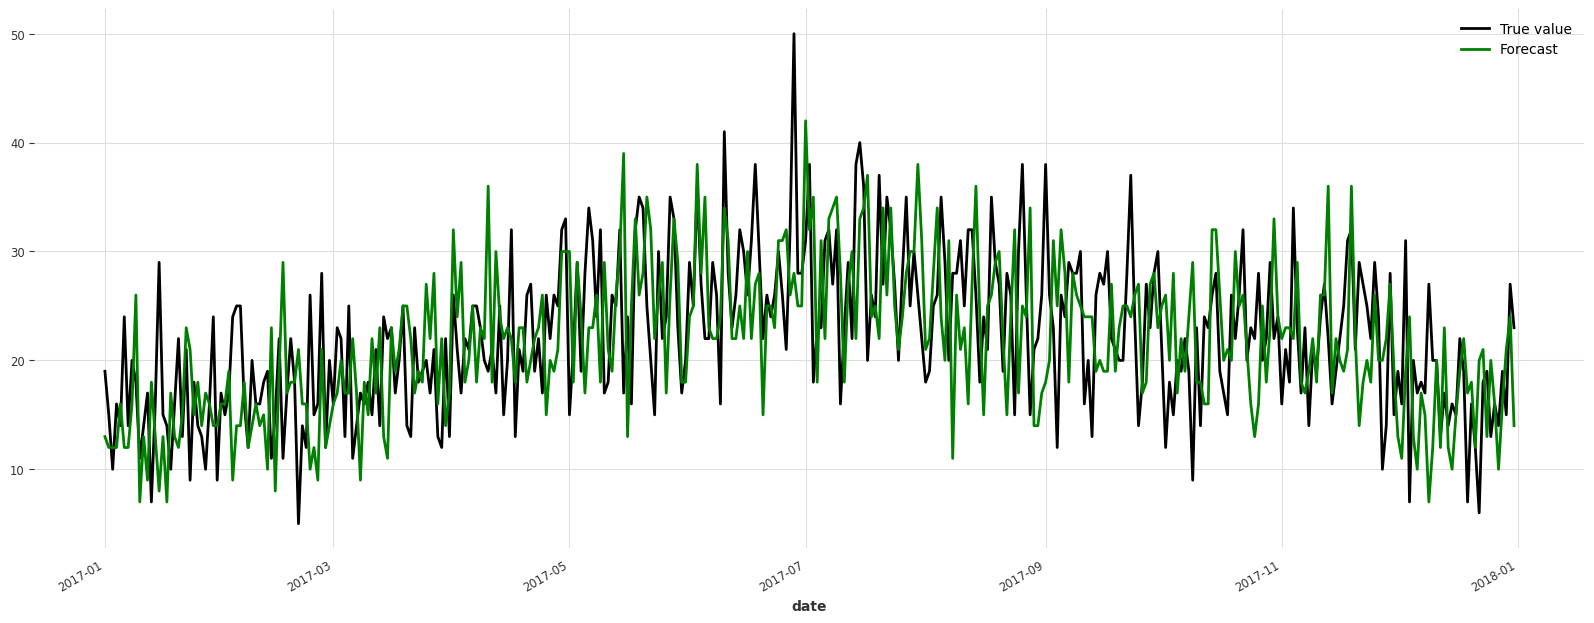

In [33]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_baseline_model[0].plot(label="Forecast", color="green")
plt.show()

It doesn’t look too bad.

## 1.2. ARIMA

<img src="figures/ARIMA.webp" style="width:800px;height:450px;background-color:white">

ARIMA is a statistical model, both popular and powerful in its simplicity. When you hear ARIMA it can mean this one model but also a collection of models that are extensions of just ARIMA. For this collection, we can include ARIMAX (takes into account additional variables), SARIMA (takes into account seasonality), or VARIMA (for multivariate time series). But let’s go back to ARIMA (AutoRegressive Integrated Moving Average), which is where it all starts. If you understand it well then you should have no problem using the mentioned before models.

Many articles have already been written about this algorithm. I would like to give you the intuition behind this model. I hope after all you will easily implement it in code and understand how it works. I am going to start from the end. I myself remember having a question about this during recruitment and at the time I didn’t understand it yet. The ARMA model can only work with stationary time series, so we have a component — Integration (I), which often (not always) transforms a non-stationary into a stationary time series. ARMA is the model, while I part is responsible for preparing the data for modeling, if necessary of course. There are a few questions you should know the answer to them, what it means that a time series is stationary or not, and what kind of transformation the Integration (I) component makes. So let’s start with stationarity.

> If the distribution of values (mean and variance) is invariant over time then the time series is stationary.

Therefore, if there is a trend and/or seasonality then a time series is non-stationary. To check whether your time series is stationary then the simplest method is to visualize it and on the graph also add the moving average and moving standard deviation. If they are constant over time (or close to constant) then you can conclude that your time series is stationary. This approach may seem naive and doesn’t always work, because given too large a window into the rolling statistics you may think your time series is stationary, when in fact it is not. Another way is to split your time series into random partitions, for each partition calculate the mentioned statistics. The last method is to calculate the Augmented Dickey-Fuller (ADF) test. What if our time series is not stationary and we need to use the Integration (I) component? It makes the time series stationary (but not always, there are time series that can’t be stationary) using differencing, that is, calculating the differences between observations. What if our time series isn’t still stationary? We can select order d, which means how many times we are differencing time series.

This long fragment was about Integration (I) which prepares data that will be used by the Autoregressive (AR) and Moving Average (MA) components. AR is a linear regression of the last p values, known as lags. The current value is correlated with and dependent on the last values. MA is complementary and takes into account the q last errors in the forecast (assumed to be white noise) to better forecast the current point in time.

To select the order p for AR we use [PACF](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) (Partial AutoCorrelation Function), while to select the order q for MA we use [ACF](https://en.wikipedia.org/wiki/Autocorrelation) (AutoCorrelation Function). Outside of university classes, we are unlikely to do this in practice because we have [AutoARIMA](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.auto_arima.html) which selects the p, d, and q for us.

Let’s go back to practice and implement in a similar way as we did with the Baseline model. As you might have read earlier thanks to the Darts library it is simple.

In [34]:
backtests_arima = backtests_multiple_local_estimators(
    estimator=StatsForecastAutoARIMA()
)
print(f"overall MAPE: {get_overall_MAPE(backtests_arima)}%")

overall MAPE: 28.2%


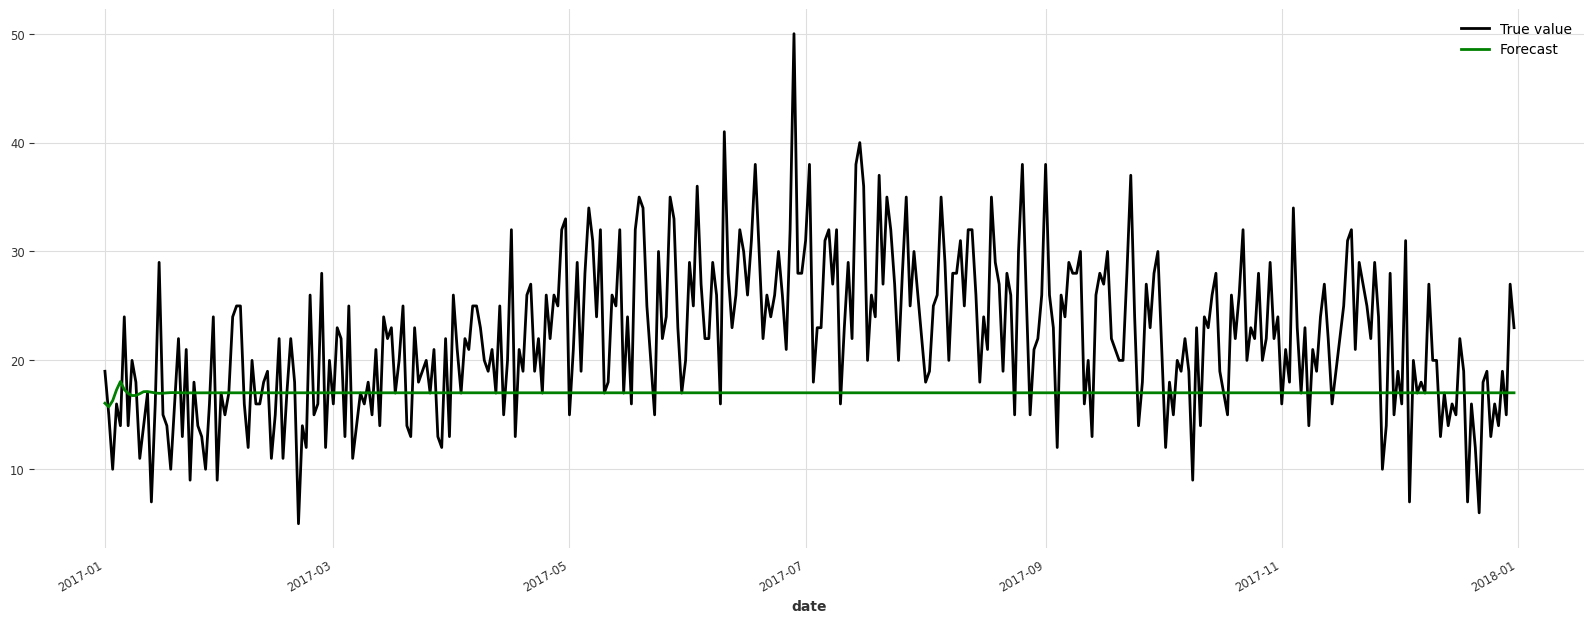

In [35]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_arima[0].plot(label="Forecast", color="green")
plt.show()

It would probably look better if I chose the parameter m (The period for seasonal differencing). You can try it and give me feedback about how the results changed.

## 1.3. Exponential smoothing

<img src="figures/exponential_smoothing.webp" style="width:800px;height:450px;background-color:white">

Exponential smoothing is another family of similar models for univariate time series. You can find ‘this family’ under the term ETS (E-Error, T-Trend, S-Seasonal). In this method, observations are weighted, for older observations are lower weights, because they decrease exponentially. We can distinguish between three types, a simple one that assumes the future will be similar to recent values, an extension that handles the trend, and the last one that also handles seasonality. I am going to describe these three types in a moment, but a small aside now. In the M-4 Competition ([Makridakis Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions), the most well-known competition for time series forecasters) Slawek Smyl won, he proposed ES-RNN, which is a hybrid between Exponential Smoothing and Recurrent Neural Network.

Now we’re back to the topic and the first type, which is Simple Exponential Smoothing. As a Baseline model, we can choose a model that always predicts the last value from the training set, a bit naive approach but can give us good results. Another approach could be to calculate the average of the whole training set, but then the same importance is given to the recent as the oldest observation. Exponential Smoothing is a combination of these two approaches, where greater weights are assigned to the most recent observations. They decrease exponentially for older observations, meaning the oldest ones will have the smallest weights. It uses an α parameter, its range is between 0 and 1. The higher the value is the greater the impact of the latest values on the prediction. Please take a look at the above graphic, where the formulas are also. They are really easy to understand and often these models give good results. Before we move on to more advanced models we should stop here for a moment, because if a simple model gives the same results as very advanced models (for example, deep neural networks) then we should stay with the simpler ones, because their operation is more predictable for us and once again, more people are able to understand their operation.

SES doesn’t handle a trend in data by the nature of the formula. If there is an increasing trend then the forecast underestimates because it doesn’t include this increase in the data. Therefore, we have another model, which is Double Exponential Smoothing. It has an additional factor that is responsible for taking into account the impact of the trend. We use the β parameter, which controls the impact of the trend change. Hence we have 2 formulas, one for level (Level equation) and the other for trend (Trend equation).

The Triple Exponential Smoothing also takes into account seasonality. You can know it as Holt-Winters’ seasonal method. Here another parameter, γ, comes into the formula. This method allows changing the level, trend, and patterns of seasonality over time. Like a trend, seasonality can be additive or multiplicative, but here I am not going to describe details assuming that you know the difference or can easily find them. I just don’t want to make a book out of this article now, and I want you to smoothly go through the whole article. 😉

In [36]:
backtests_exponential_smoothing = backtests_multiple_local_estimators(
    estimator=ExponentialSmoothing()
)
print(f"overall MAPE: {get_overall_MAPE(backtests_exponential_smoothing)}%")

overall MAPE: 32.19%


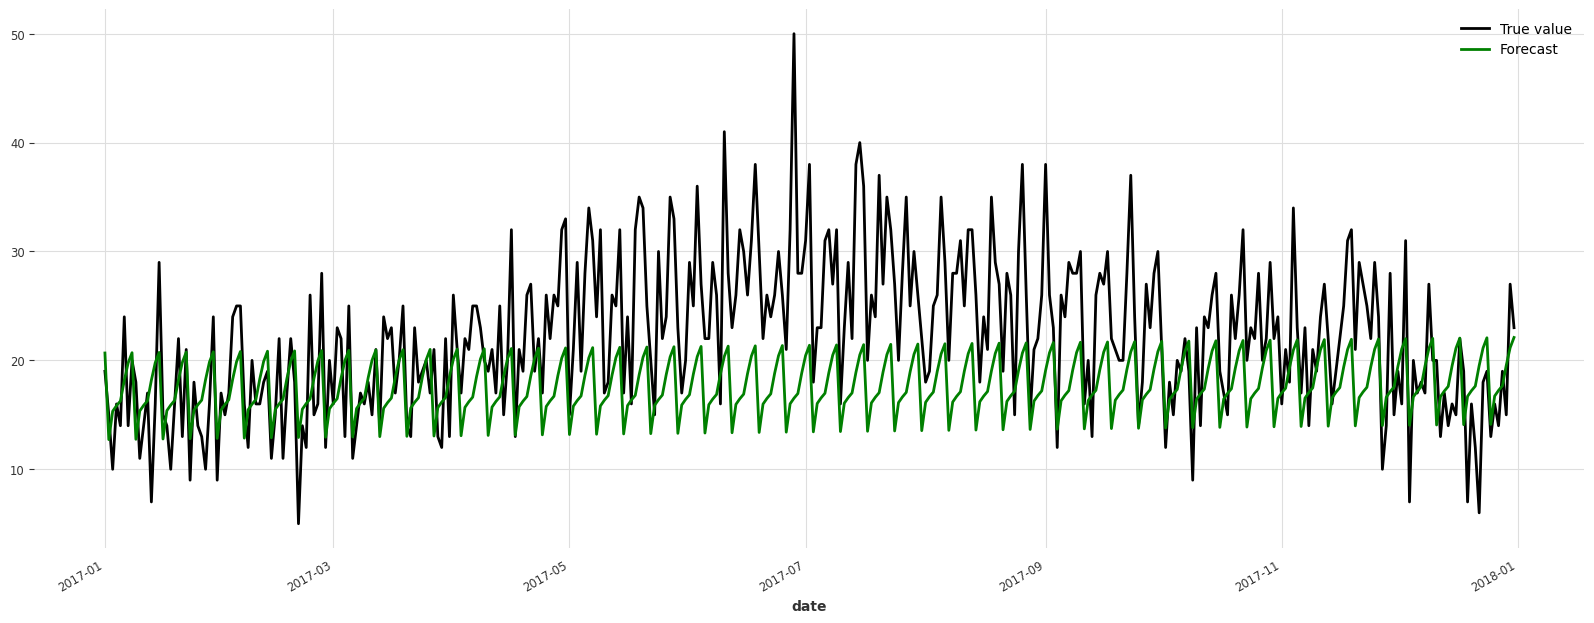

In [37]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_exponential_smoothing[0].plot(label="Forecast", color="green")
plt.show()

As for ARIMA, I did not add seasonality information. Now is your step, add this information using the seasonal_periods parameter for [Exponential Smoothing](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html).

## 1.4. Prophet

<img src="figures/prophet.webp" style="width:800px;height:450px;background-color:white">

[Prophet](https://facebook.github.io/prophet/) was proposed in the [Forecasting at scale](https://peerj.com/preprints/3190.pdf) paper from 2017 by Facebook. It is both a model and a library by the same name. Like the previous models, you will find this one at Darts. This algorithm is a Generalized Additive Model, so the forecast is the sum of components. These components are g(t) — trend, s(t) — seasonality (yearly, weekly, and daily), and h(t) — the effect of holidays.

> y(t) = g(t) + s(t) + h(t) + error(t)

The first one is the trend, it can change over time and doesn’t have to be constant over time. When students start learning classes with analyzing time series, they usually work with simple time series. In a time series, they can see a continuous growth trend. However, in real data, the trend can change several times. Prophet has implemented changepoints (think of them as a hyperparameter, such as their number, range, and prior scale). These points are trend changes, for example, increase trend -> changepoint -> decrease trend -> changepoint -> stronger decrease trend, and so on. This approach is closer to what we can usually see in the data. Positions of these changepoints Prophet set behind of you. The trend function between changepoints can be a simple regression.

Next, we have the seasonality function which is the Fourier series.

Another function is the holiday effect, which adds or subtracts value to our forecast. You can use the dates that the Prophet library provides or define your own events. You can imagine that the Black Friday effect significantly affects the value of sales. In addition, you can take into account the range around the date where the holiday affects the forecast, for example, Christmas does not affect sales on the day of the holiday, but the days before (many days).

In [38]:
backtests_prophet = backtests_multiple_local_estimators(estimator=Prophet())
print(f"overall MAPE: {get_overall_MAPE(backtests_prophet)}%")

overall MAPE: 14.38%


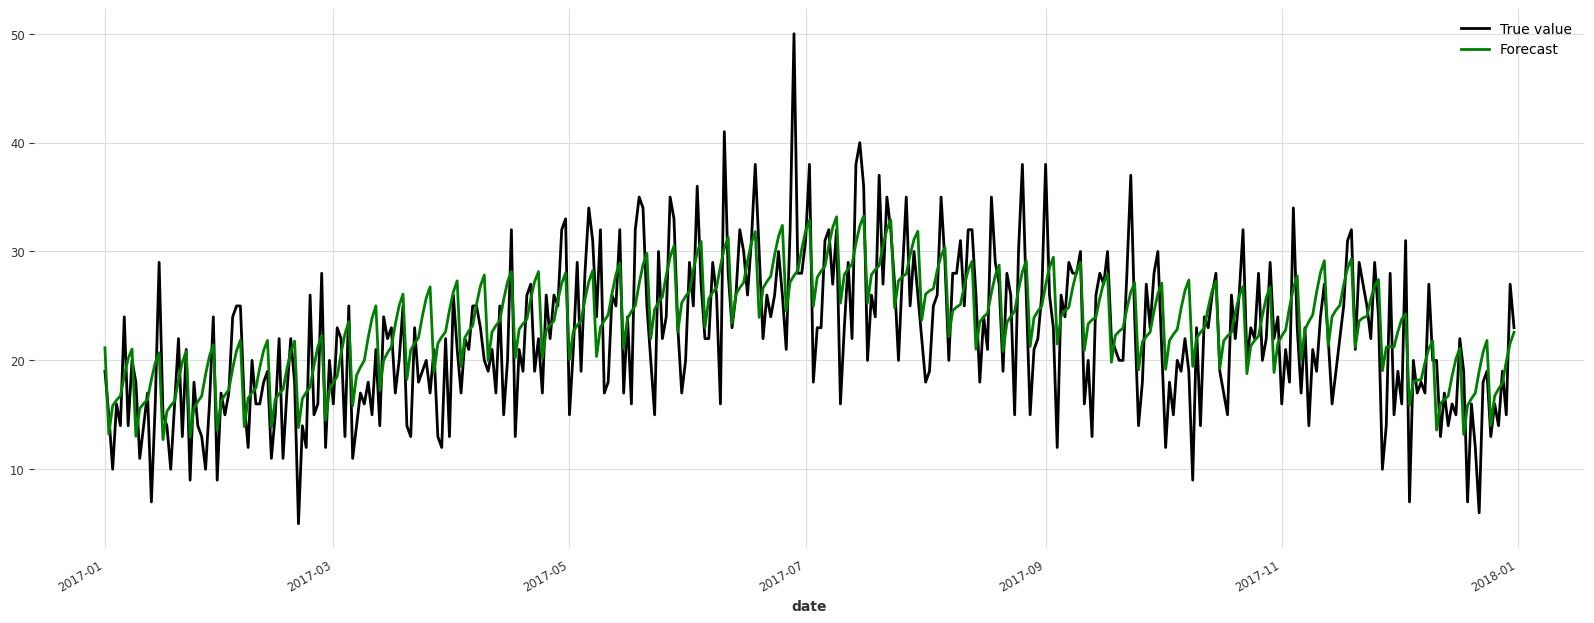

In [39]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_prophet[0].plot(label="Forecast", color="green")
plt.show()

# 2. Global models

Now let’s turn to the approach where we have one model for all time series. This is also known as cross-learning, because the model to make a good prediction of time series A learned the relationships from time series A and also B, C, D, etc.

## 2.1. Supervised Model ~ Time Series as a regression problem

<img src="figures/supervised_model.webp" style="width:800px;height:450px;background-color:white">

Now let’s try to apply supervised learning models to time series forecasting. This is nothing new, but they often give great results and are better than neural networks (see the best solutions from M-5 Competition). However, regression models are not dedicated to time series, so if we want to use them we need to convert the time series problem into a machine learning problem. I wrote more about this in my previous article Sell Out Sell In Forecasting, but I will also now describe how to use the well-known regression algorithms for this problem.

Before I start with the previously mentioned transformation, we first need to scale the data. Earlier I described the need for this transformation for global models. In this case, I used MinMaxScaler.

The next step is feature engineering, which is the transformation that was repeated several times. Based on the history of the time series, we create features that will help the model better forecast the future. These variables can refer to the recent history of selected time series, such as lagged values (for weekly data t-1W, t-2W, t-3W, and so on). Another example is the calculation of rolling statistics, median (it can be a median of the recent 4 weeks), mean, min, max, std, and whatever you are going to calculate on the window. If there is seasonality in the data then it is good to give the model a hint as to where in time the t is. I often use the sin and cos of a cyclic variable (in the above visualization it is a day of the year and a day of the week).

The last step is to choose a model, you have a wide range of choices, so it can be Linear regression, Linear mixed effect model, Random Forest, LightGBM, and much more. The choice of model depends on the nature of the time series and the complexity of the problem. Another question might be if you want one model or as many models as horizons. When you choose a model then you need to keep in mind its weaknesses. For example, when you choose Random Forest then remember that the leaf counts the mean, so it can’t go beyond the training range. LightGBM doesn’t have this problem because it doesn’t count a naive mean, but regression is counted in the background.

Now it’s time again to return to the practical part and implement the model in code. I chose [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/) as the model. Using it in Darts is much easier than in a similar way I would like to use it without this library. As you can see in the code we are using the lags of the last 14 days. I also added encoders that add covariates used by the model and they are added automatically and everything counts inside.

- `cyclic` — adds 2 columns, sin cos encoding based on cyclic variable, here month
- `datetime_attribute` — adds scalar based on datetime variable
- `position` — adds the relative index positions as integer values based on time series index, where 0 is set at the forecasting point.

In [40]:
model_lightGBM = LightGBMModel(
    lags=14,
    output_chunk_length=365,
    random_state=0,
    multi_models=False,
    add_encoders={
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["dayofweek"]},
        "position": {"past": ["relative"], "future": ["relative"]},
        "transformer": Scaler(),
    },
)

In [41]:
model_lightGBM.fit(series=train_dataset_ts_prepared)

[LightGBM] [Warning] Unknown parameter: multi_models


In [42]:
backtests_lightGBM = model_lightGBM.predict(
    n=forecast_horizons, series=train_dataset_ts_prepared
)

In [43]:
# The model predicts scaled values, but then we have to reverse the transformation
backtests_lightGBM = scaler.inverse_transform(backtests_lightGBM)

In [44]:
print(f"overall MAPE: {get_overall_MAPE(backtests_lightGBM)}%")

overall MAPE: 20.49%


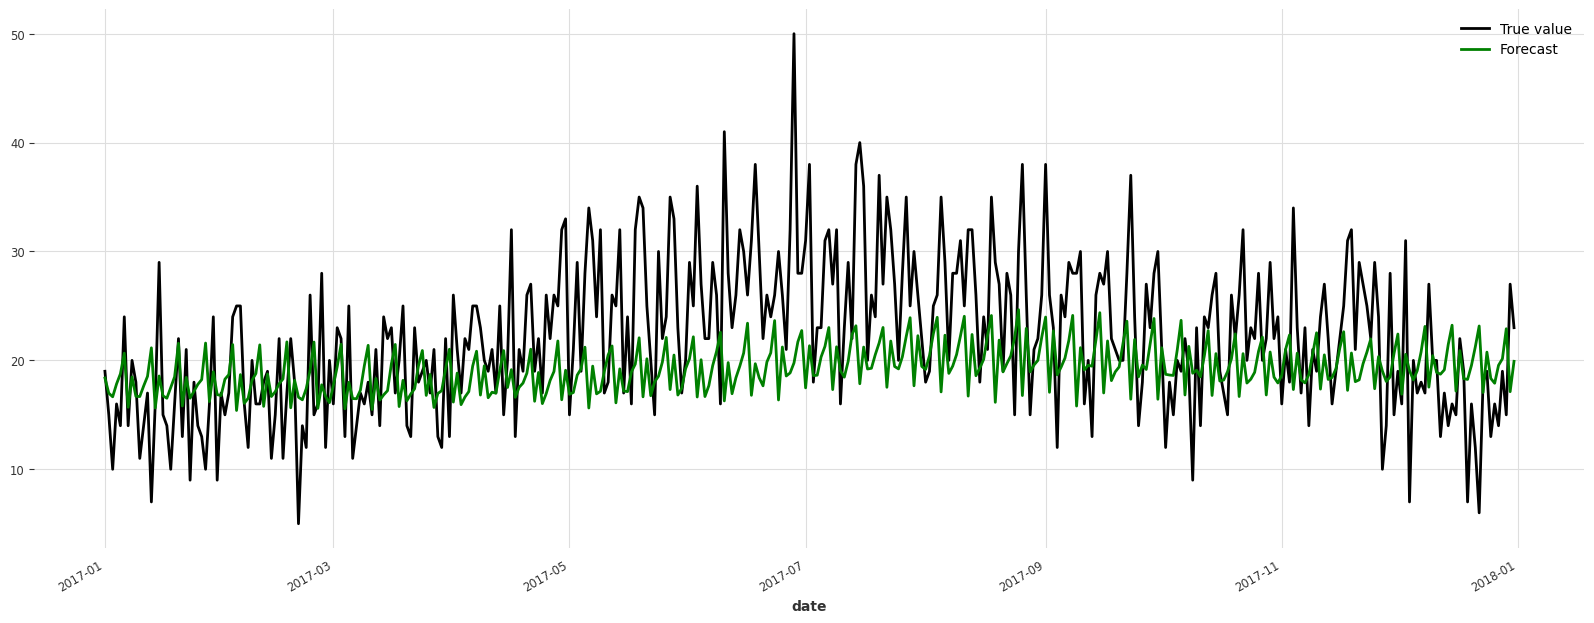

In [45]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_lightGBM[0].plot(label="Forecast", color="green")
plt.show()

The results are really promising especially since this is one model for all time series. However, I would like to warn you based on my experience. These types of models work well based on feature engineering, which is an advantage and a big disadvantage. Suppose you are using lags and moving mean. You are now going to forecast the value of one of the time series, but you have anomalies in it — several large values before the forecast point. Your model will definitely overestimate. When you create variables then try to imagine what effect they will have on the model.

## 2.2. DeepAR

<img src="figures/DeepAR.webp" style="width:800px;height:450px;background-color:white">

[DeepAR](https://arxiv.org/abs/1704.04110) is a deep learning algorithm developed by Amazon team. It is designed to model the complex dependencies and relationships in time series data using recurrent neural networks (RNNs).

As we can read in Abstract (which is very close to me):

> In retail businesses, for example, forecasting demand is crucial for having the right inventory available at the right time at the right place.

The model is autoregressive and generates a probabilistic forecast using Monte Carlo samples. The NN architecture is based on the LSTM layer. With a probabilistic approach, we are not interested in a single good prediction, but rather in the full predictive distribution of where the true value can be found. Instead of using LSTMs to calculate predictions directly, DeepAR leverages LSTMs to parameterize a Gaussian likelihood function. That is, to estimate mean and standard deviation of the Gaussian function (θ = (μ, σ) parameters).

DeepAR supports Future-known covariates, we don’t have such, but let’s create them. As these features, I created OHE with the day of the week and the month. Probably a better approach would be sin and cos, I encourage you to experiment and return to me with your feedback.

In [46]:
day_series = datetime_attribute_timeseries(
    dataset_ts[0], attribute="weekday", one_hot=True, dtype=np.float32
)

In [48]:
month_series = datetime_attribute_timeseries(
    dataset_ts[0], attribute="month", one_hot=True, dtype=np.float32
)

In [49]:
day_month_series = day_series.concatenate(
    month_series, axis=1, ignore_static_covariates=True
)

In [53]:
model_deepar = RNNModel(
    model="LSTM",
    hidden_dim=10,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=32,
    n_epochs=5,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=21,
    input_chunk_length=14,
    likelihood=GaussianLikelihood(),
    # pl_trainer_kwargs={"accelerator": "gpu", "devices": [0]},
)

In [54]:
model_deepar.fit(
    series=train_dataset_ts_prepared,
    future_covariates=[day_month_series] * len(train_dataset_ts_prepared),
    verbose=True,
)

Training: 0it [00:00, ?it/s]

In [55]:
backtests_deepar = model_deepar.predict(
    n=forecast_horizons,
    series=train_dataset_ts_prepared,
    future_covariates=[day_month_series] * len(train_dataset_ts_prepared),
    num_samples=1000,
    verbose=True,
)

Predicting: 22500it [00:00, ?it/s]

In [56]:
backtests_deepar = scaler.inverse_transform(backtests_deepar)

In [57]:
print(f"overall MAPE: {get_overall_MAPE(backtests_deepar)}%")

overall MAPE: 19.89%


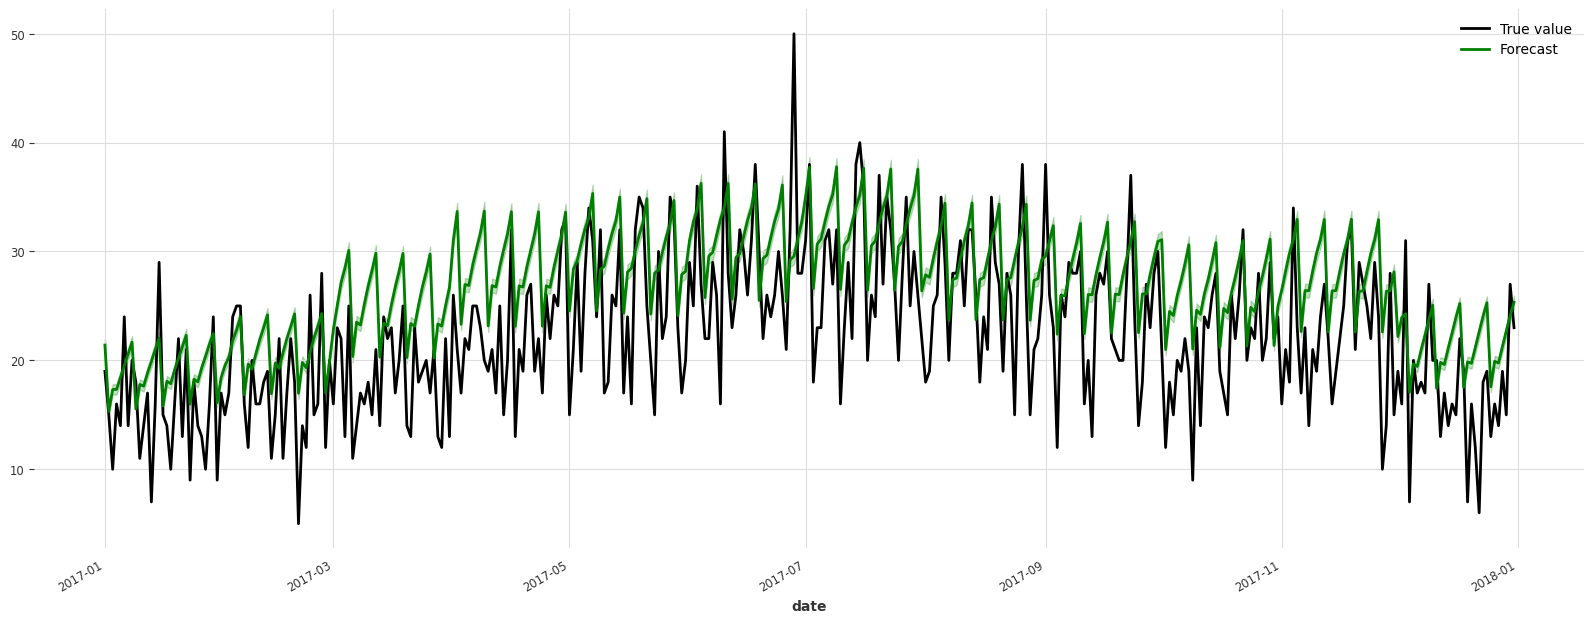

In [58]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_deepar[0].plot(label="Forecast", color="green")
plt.show()

## 2.3. N-BEATS

<img src="figures/N-BEATS.webp" style="width:800px;height:450px;background-color:white">

[N-BEATS](https://arxiv.org/abs/1905.10437) (Neural basis expansion analysis for interpretable time series forecasting) is a deep learning algorithm, but it doesn’t include recurrent layers, such as LSTM or GRU.

The architecture may seem complex, but once you get into the details it is quite simple and is a combination of blocks and all layers are feed forward.

Let’s start with the smallest element, the block, each of them has one input and generates two outputs. The input is lookback period. Outputs are the forecast and the backcast. I think the idea of forecast is easy for you. Backcast is prediction, but for lockback period — it is fitted value and show how well block has relationship on the lookback period window.

Let’s move on to stacks, or the combination of multiple blocks. As you read, each block has two outputs and one input. The next blocks are responsible for forecasting residuals — similar to what happens in boosting forest models, like AdaBoost. In each step, the backcast generated by the block is subtracted from the input of the block before. At the end, all forecasts from blocks are aggregated. In addition, it is an interpretable model, you can decompose and see the effect of trend and seasonality.

Now let’s move on to the combined stacks. This part increases the depth of the model and provides an opportunity to learn more about complexity.

In [59]:
model_nbeats = NBEATSModel(
    input_chunk_length=178,
    output_chunk_length=356,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_interpretable_run",
    random_state=0,
    # pl_trainer_kwargs={
    #   "accelerator": "gpu",
    #   "devices": [0]
    # }
)

In [60]:
model_nbeats.fit(series=train_dataset_ts_prepared, verbose=True)

Training: 0it [00:00, ?it/s]

In [61]:
backtests_nbeats = model_nbeats.predict(
    n=forecast_horizons, series=train_dataset_ts_prepared, verbose=True
)

Predicting: 580it [00:00, ?it/s]

In [62]:
backtests_nbeats = scaler.inverse_transform(backtests_nbeats)

In [63]:
print(f"overall MAPE: {get_overall_MAPE(backtests_nbeats)}%")

overall MAPE: 13.15%


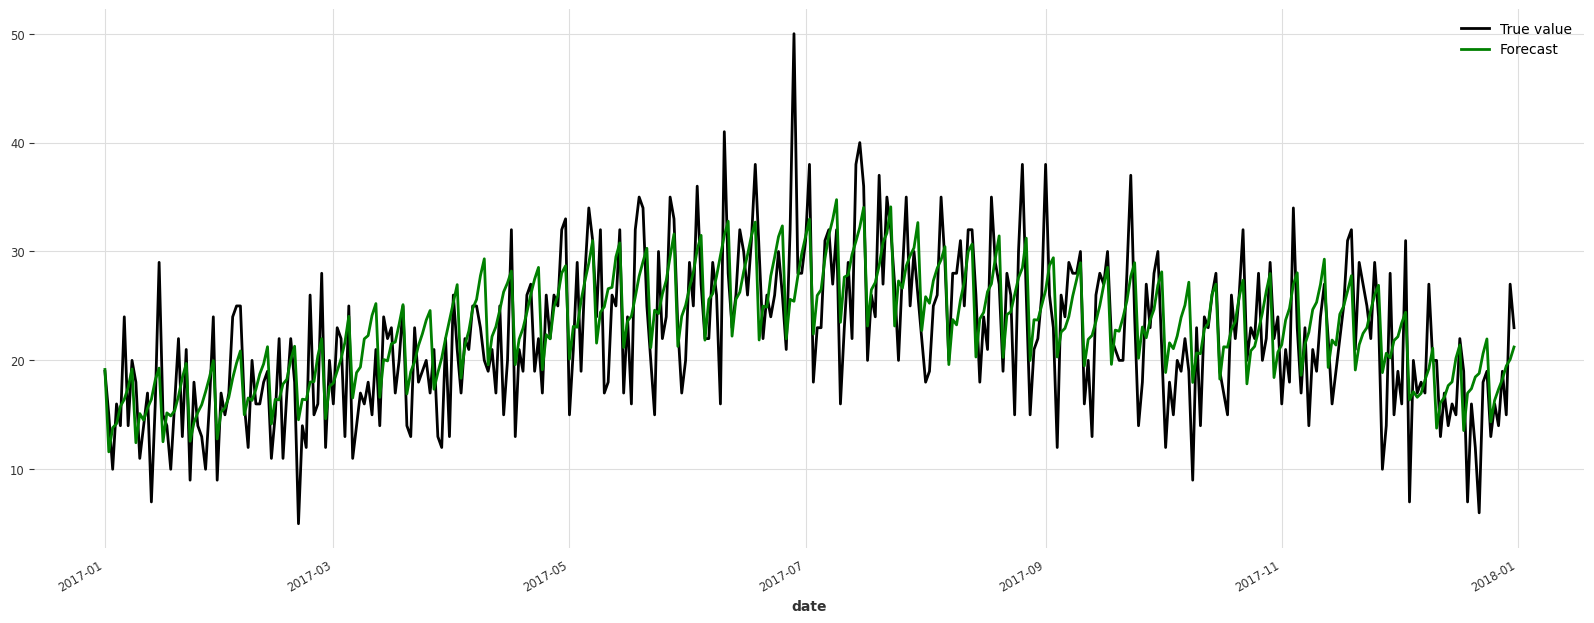

In [64]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_nbeats[0].plot(label="Forecast", color="green")
plt.show()

## 2.4. TFT

<img src="figures/TFT.webp" style="width:800px;height:450px;background-color:white">

[Temporal Fusion Transformers](https://arxiv.org/abs/1912.09363) (TFT) is a deep learning algorithm developed by Google for time series forecasting. It is designed to model the complex dependencies and relationships in time series data using a combination of transformer networks and autoregressive modeling.

TFT is the most complex architecture and uses various techniques underneath. It is like an onion, composed of many layers. Also based on my experience, it learns the longest time compared to the above models. TFT uses a multi-head attention block to find long-time patterns, but LSTM sequence-to-sequence encoders/decoders to find these shorter patterns.

In [65]:
model_tft = TFTModel(
    input_chunk_length=28,
    output_chunk_length=356,
    hidden_size=16,
    lstm_layers=1,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=32,
    n_epochs=5,
    add_encoders={
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["dayofweek"]},
        "position": {"past": ["relative"], "future": ["relative"]},
        "transformer": Scaler(),
    },
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    # pl_trainer_kwargs={
    #   "accelerator": "gpu",
    #   "devices": [0]
    # }
)

In [66]:
model_tft.fit(series=train_dataset_ts_prepared, verbose=True)

Training: 0it [00:00, ?it/s]

In [67]:
backtests_tft = model_tft.predict(
    n=forecast_horizons,
    series=train_dataset_ts_prepared,
    num_samples=1000,
    verbose=True,
)

Predicting: 16844it [00:00, ?it/s]

In [68]:
backtests_tft = scaler.inverse_transform(backtests_tft)

In [69]:
print(f"overall MAPE: {get_overall_MAPE(backtests_tft)}%")

overall MAPE: 13.73%


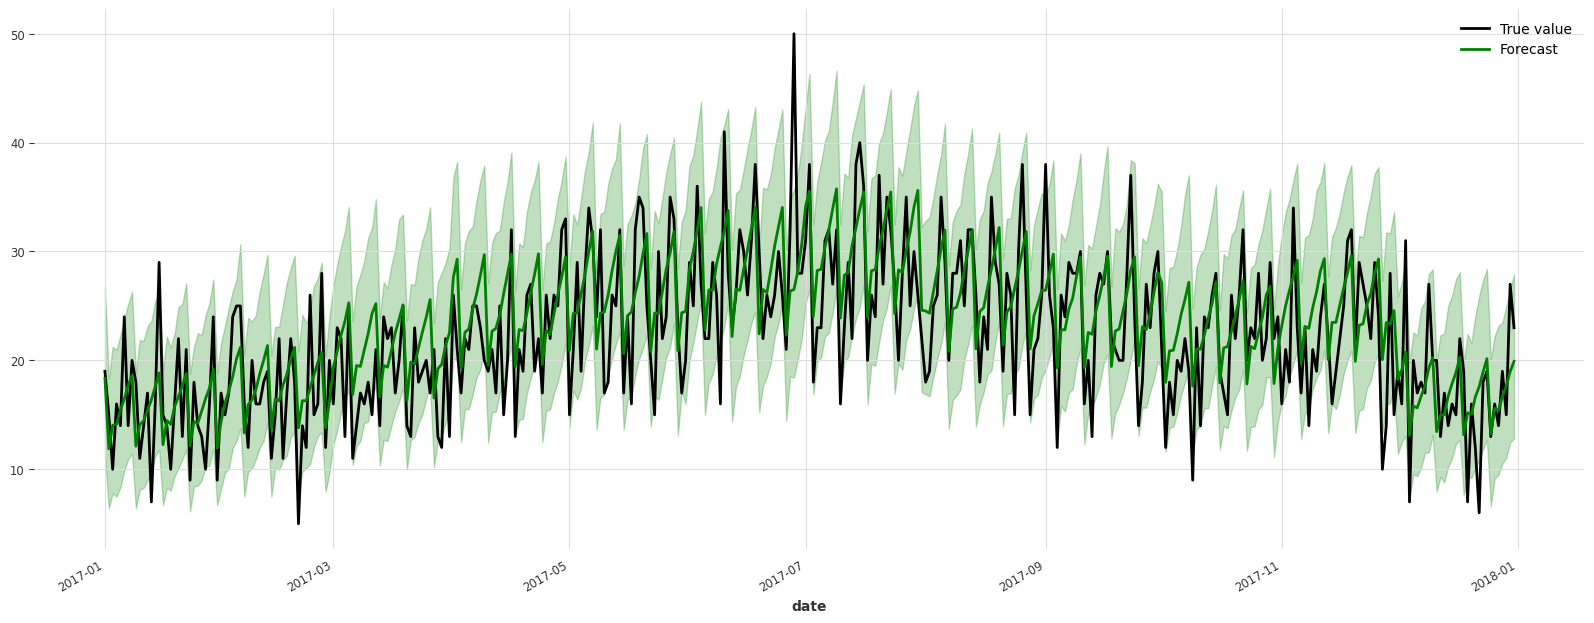

In [70]:
fig, ax = plt.subplots(figsize=(20, 7))
test_dataset_ts[0].plot(label="True value", color="black")
backtests_tft[0].plot(label="Forecast", color="green")
plt.show()

# Summary

In this article, I wanted to show you what approaches you can choose to forecast multiple time series. I have provided you with fully practical code, feel free to use them and don’t hesitate to write to me.

This was just an introduction to the topic. I think also relevant from the work of Data Scientists for Supply Chain companies are the following topics:
- Hierarchical forecasting and then combining forecasts from different hierarchies, i.e. Hierarchical Reconciliation. We can make a forecast at the store level and also at the country level, but when we aggregate the forecast at the store level then as a sum we would like to get the same thing that the forecast at the country level shows. That is why Hierarchical Reconciliation is important.
- Another topic is inventory optimization, i.e. how many products we should have in stock so that we don’t have a situation where we don’t have our products in stock, but on the other hand, we don’t stock one product for months.